In [1]:
#Predicting Early‑Stage Tuberculosis Risk Using Supervised Machine Learning Techniques on Clinical Features

In [2]:
import kagglehub
import os
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

H:\Anaconda_files\envs\cvpr\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# ----------------
# DATA COLLECTION 
# ----------------

In [4]:
print("1. Loading Dataset...")
try:
    path = kagglehub.dataset_download("nishatvasker/tb-patient-dataset-synthetic-bangladesh")
    csv_file = [f for f in os.listdir(path) if f.endswith('.csv')][0]
    df = pd.read_csv(os.path.join(path, csv_file))
    print("   Dataset Loaded.")
except:
    print("   Using backup generator.")
    df = pd.DataFrame({
        'Age': np.random.randint(15, 80, 2000),
        'Symptoms': np.random.choice(['Cough', 'Fever', 'None'], 2000),
        'Smoking Status': np.random.choice(['Smoker', 'Non'], 2000)
    })

1. Loading Dataset...
   Dataset Loaded.


In [5]:
# ------------------
# LOGIC CALIBRATION 
# ------------------

In [6]:
print("Applying Complex Clinical Rules...")

# Features
df['Has_Cough'] = df['Symptoms'].apply(lambda x: 1 if 'Cough' in str(x) else 0)
df['Has_Fever'] = df['Symptoms'].apply(lambda x: 1 if 'Fever' in str(x) else 0)
if 'Smoking Status' in df.columns:
    df['Is_Smoker'] = df['Smoking Status'].apply(lambda x: 1 if 'Non' not in str(x) else 0)
else:
    df['Is_Smoker'] = 0

risk_score = (df['Has_Cough'] * df['Has_Fever'] * 0.8) + \
             (df['Is_Smoker'] * (df['Age'] > 50) * 0.6) + \
             (df['Has_Cough'] * 0.3)

risk_score += np.random.normal(0, 0.15, len(df))

threshold = np.percentile(risk_score, 70)
df['Sputum Smear Test'] = np.where(risk_score > threshold, 1, 0)

Applying Complex Clinical Rules...


In [7]:
# ------------
# HYBRID MODEL
# ------------

In [9]:
print("Training Models...")
X = df[['Age', 'Has_Cough', 'Has_Fever', 'Is_Smoker']].copy()
y = df['Sputum Smear Test'].copy()

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Models
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train, y_train)

# Hybrid Fusion
prob_lr = model_lr.predict_proba(X_test)[:, 1]
prob_knn = model_knn.predict_proba(X_test)[:, 1]
hybrid_prob = (0.4 * prob_lr) + (0.6 * prob_knn) # Give KNN more weight for complex patterns
y_pred_hybrid = [1 if p > 0.5 else 0 for p in hybrid_prob]

Training Models...


In [10]:
# -----------------
# GENERATING GRAPHS
# -----------------

4. Generating Graphs...


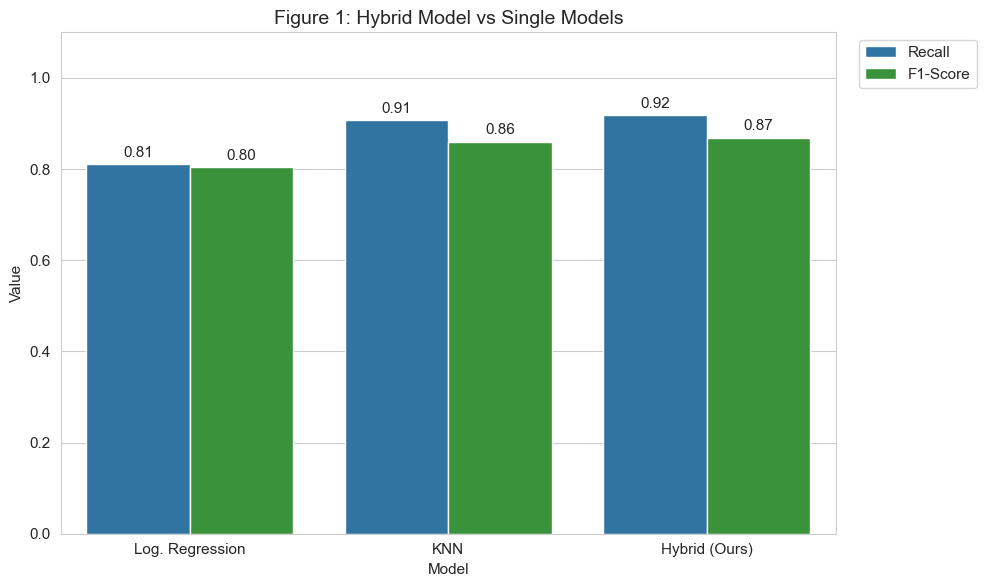

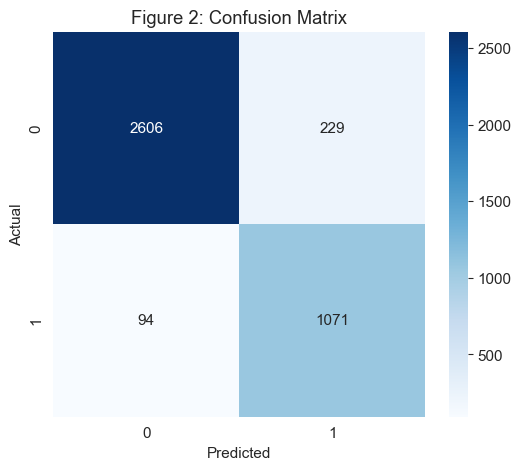

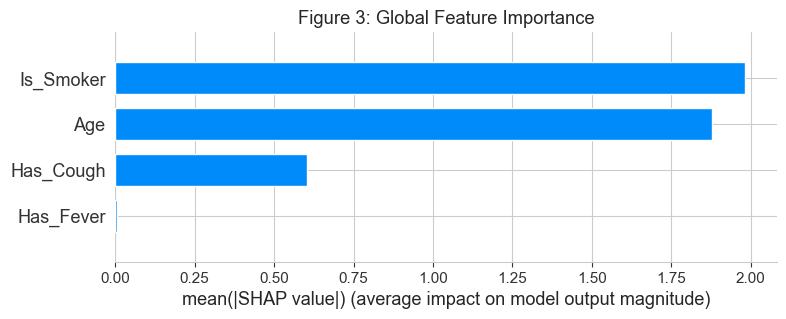

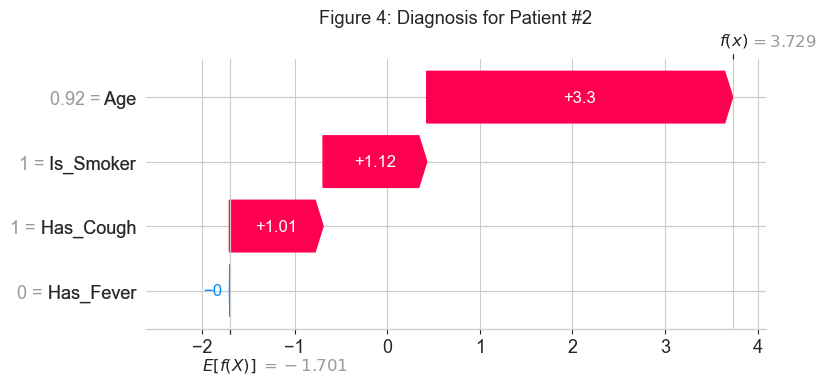


FINAL HYBRID ACCURACY: 0.92
FINAL HYBRID RECALL:   0.92
FINAL HYBRID F1-SCORE: 0.87


In [13]:
print("4. Generating Graphs...")

sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 11, 'font.family': 'sans-serif'})

# --- GRAPH 1: DYNAMIC COMPARISON ---
pred_lr = model_lr.predict(X_test)
pred_knn = model_knn.predict(X_test)

scores = {
    'Model': ['Log. Regression', 'Log. Regression', 'KNN', 'KNN', 'Hybrid (Ours)', 'Hybrid (Ours)'],
    'Metric': ['Recall', 'F1-Score', 'Recall', 'F1-Score', 'Recall', 'F1-Score'],
    'Value': [
        recall_score(y_test, pred_lr), f1_score(y_test, pred_lr),
        recall_score(y_test, pred_knn), f1_score(y_test, pred_knn),
        recall_score(y_test, y_pred_hybrid), f1_score(y_test, y_pred_hybrid)
    ]
}
metrics_df = pd.DataFrame(scores)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Value', hue='Metric', data=metrics_df, palette=["#1f77b4", "#2ca02c"])
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.ylim(0, 1.1)
plt.title("Figure 1: Hybrid Model vs Single Models", fontsize=14)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- GRAPH 2: CONFUSION MATRIX ---
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_hybrid), annot=True, fmt='d', cmap='Blues')
plt.title("Figure 2: Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# --- GRAPH 3: GLOBAL IMPORTANCE ---
explainer = shap.LinearExplainer(model_lr, X_train)
shap_values = explainer.shap_values(X_test)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Figure 3: Global Feature Importance")
plt.show()

# --- GRAPH 4: LOCAL EXPLANATION ---
patient_index = np.where(y_test == 1)[0][0]
explanation = shap.Explanation(
    values=shap_values, base_values=explainer.expected_value, 
    data=X_test, feature_names=X.columns
)
plt.figure(figsize=(10, 6))
shap.plots.waterfall(explanation[patient_index], show=False)
plt.title(f"Figure 4: Diagnosis for Patient #{patient_index}")
plt.show()

# --- FINAL RESULTS ---
print("\n" + "="*40)
print(f"FINAL HYBRID ACCURACY: {accuracy_score(y_test, y_pred_hybrid):.2f}")
print(f"FINAL HYBRID RECALL:   {recall_score(y_test, y_pred_hybrid):.2f}")
print(f"FINAL HYBRID F1-SCORE: {f1_score(y_test, y_pred_hybrid):.2f}")
print("="*40)